In [ ]:
####################  NQPS  ########################


# ver4.8

############################################
##### decide which real machine to use #####
############################################
backend_name = 'ibm_kawasaki'

############################
##### import libraries #####
############################
%matplotlib inline
%load_ext autoreload
%autoreload 2


from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, compiler, circuit, compiler
from qiskit.converters import circuit_to_dag, dag_to_circuit
from pytket.extensions.qiskit import IBMQBackend, AerBackend
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import math
import time
import sys
sys.path.append('../../../aqcel_dev/aqcel_dev')
import aqcel_dev as icepp
sys.path.append('../')
sys.path.append('../qiskit_legacy')
sys.path.append('../qiskit_code')

import QuantumPartonShower as qps
import QuantumPartonShower_ReM as qpsc
import QuantumPartonShower_ReM_2step_hardcode as qps_rhs
import plotting as pl
from PaperPlots import MakeObservables as mo

sim_b = AerBackend()

# style = {'displaycolor' : displaycolor, 'showindex' : True}

Number of emissions: 1
log(theta_max): -5.180816459236603
Number of emissions: 1
log(theta_max): -1.7269388197455342
Number of emissions: 2
log(theta_max): -1.7269388197455342
Number of emissions: 1
log(theta_max): -3.4538776394910684


In [ ]:
N = 1
eps= 0.001
g_1= 2
g_2= 1
initialParticles= ['100'] # f1

shots= 2000

qps0= qps.QuantumPartonShower(N, 1) # for g12= 0
qps1= qps.QuantumPartonShower(N, 1) # for g12= 1

qc0, qubits0= qps0.createCircuit(eps, g_1, g_2, 0, initialParticles)
qc1, qubits1= qps1.createCircuit(eps, g_1, g_2, 1, initialParticles)

t1= time.time()
counts0= qps0.simulate('qasm', shots=shots)
t2= time.time()
counts1= qps1.simulate('qasm', shots=shots)
t3= time.time()

generated circuit on 11 qubits
generated circuit on 11 qubits


In [ ]:
#######################
##### apply aqcel #####
#######################

# AQCELにかかる時間を測定開始
start_time = time.time()

# AQCELのapply
qc0 = qc1
target_qc = qc0

print(f'type of target_qc is {type(target_qc)}')

aqcel_results_cc= icepp.pass_manager(target_qc, level=2, backend_tket=sim_b, shots=1024, measure_type='cc').auto_manager()
result_qc = aqcel_results_cc[0]

# qc1, qc2, qc3, qc4, qc6 = aqcel_results_cc[9], aqcel_results_cc[10], aqcel_results_cc[11], aqcel_results_cc[12], aqcel_results_cc[1]

# AQCEL適用にかかった時間をprint
end_time = time.time()
execution_time = end_time - start_time
print(f"実行時間: {execution_time}秒")

type of target_qc is <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
実行時間: 6.654390811920166秒


In [ ]:
#############################
##### Before AQCEL(qc) #####
#############################
qc = target_qc
print('Before AQCEL(qc)')
print(f' - Number of gate   : {list(target_qc.count_ops().items())}')
print(f' - Number of qubits : {target_qc.num_qubits}')
print(f' - Depth of all     : {target_qc.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')



############################
##### After AQCEL(qc5) #####
############################
qc5 = result_qc
print('After AQCEL(qc5) : After remove_qubits')
print(f' - Number of gate   : {list(result_qc.count_ops().items())}')
print(f' - Number of qubits : {result_qc.num_qubits}')
print(f' - Depth of all     :{result_qc.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')


# かかる時間を測定開始
start_time = time.time()

import qiskit.quantum_info as qi
statevector1 = icepp.simulator(target_qc).statevector_simulator(output='statevector')
statevector2 = icepp.simulator(result_qc).statevector_simulator(output='statevector')
dm1 = qi.partial_trace(statevector1,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm1.probabilities_dict()
dm2 = qi.partial_trace(statevector2,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm2.probabilities_dict()

# かかった時間をprint
end_time = time.time()
execution_time = end_time - start_time
print(f"実行時間: {execution_time}秒")
print(f"Fsim = {qi.state_fidelity(dm1,dm2)}")

Before AQCEL(qc)
 - Number of gate   : [('ccx', 149), ('x', 126), ('measure', 20), ('cry', 17), ('cx', 7), ('ch', 1)]
 - Number of qubits : 20
 - Depth of all     : 173


After AQCEL(qc5) : After remove_qubits
 - Number of gate   : [('cx', 30), ('measure', 20), ('x', 16), ('cry', 4), ('ccx', 4), ('ry', 2)]
 - Number of qubits : 20
 - Depth of all     :42


実行時間: 2.236149311065674秒
Fsim = 1.0000000000000075


In [ ]:
############################
##### Before AQCEL(qc5)(decomposed) #####
############################
qc0_decomposed = qc0.decompose()
print('Before AQCEL(qc5)(decomposed)')
print(f' - Number of gate   : {list(qc0_decomposed.count_ops().items())}')
print(f' - Number of qubits : {qc0_decomposed.num_qubits}')
print(f' - Depth of all     :{qc0_decomposed.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')


############################
##### After AQCEL(qc5)(decomposed) #####
############################
qc5_decomposed = qc5.decompose()
print('After AQCEL(qc5)(decomposed)')
print(f' - Number of gate   : {list(qc5_decomposed.count_ops().items())}')
print(f' - Number of qubits : {qc5_decomposed.num_qubits}')
print(f' - Depth of all     :{qc5_decomposed.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')

Before AQCEL(qc5)(decomposed)
 - Number of gate   : [('cx', 936), ('t', 597), ('tdg', 448), ('h', 300), ('u3', 126), ('ry', 34), ('measure', 20), ('s', 1), ('sdg', 1)]
 - Number of qubits : 20
 - Depth of all     :1230


After AQCEL(qc5)(decomposed)
 - Number of gate   : [('cx', 62), ('measure', 20), ('u3', 16), ('t', 16), ('tdg', 12), ('h', 8), ('ry', 8), ('r', 2)]
 - Number of qubits : 20
 - Depth of all     :84




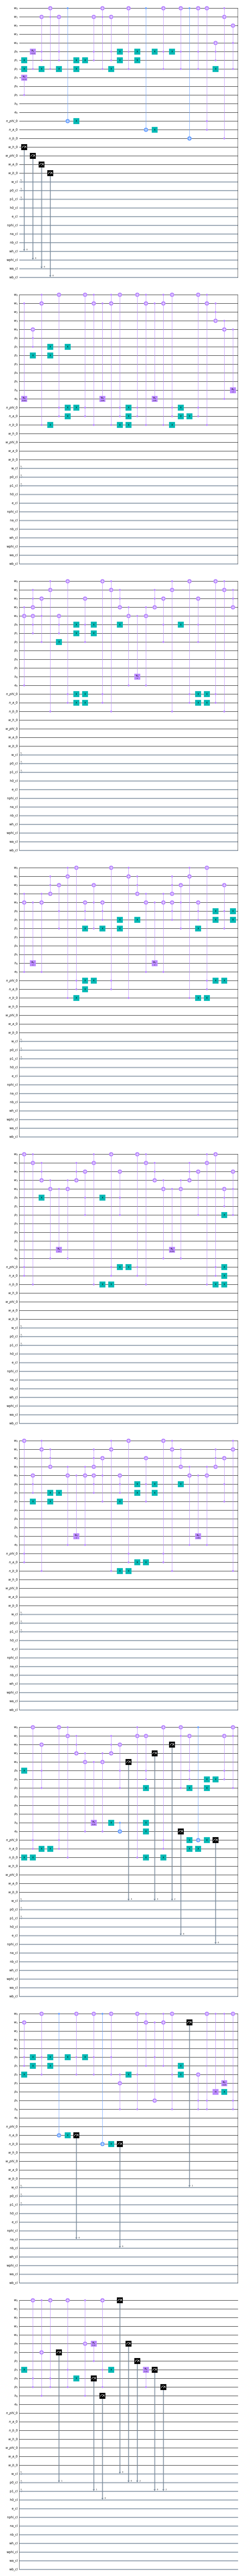

In [ ]:
qc0.draw('mpl')

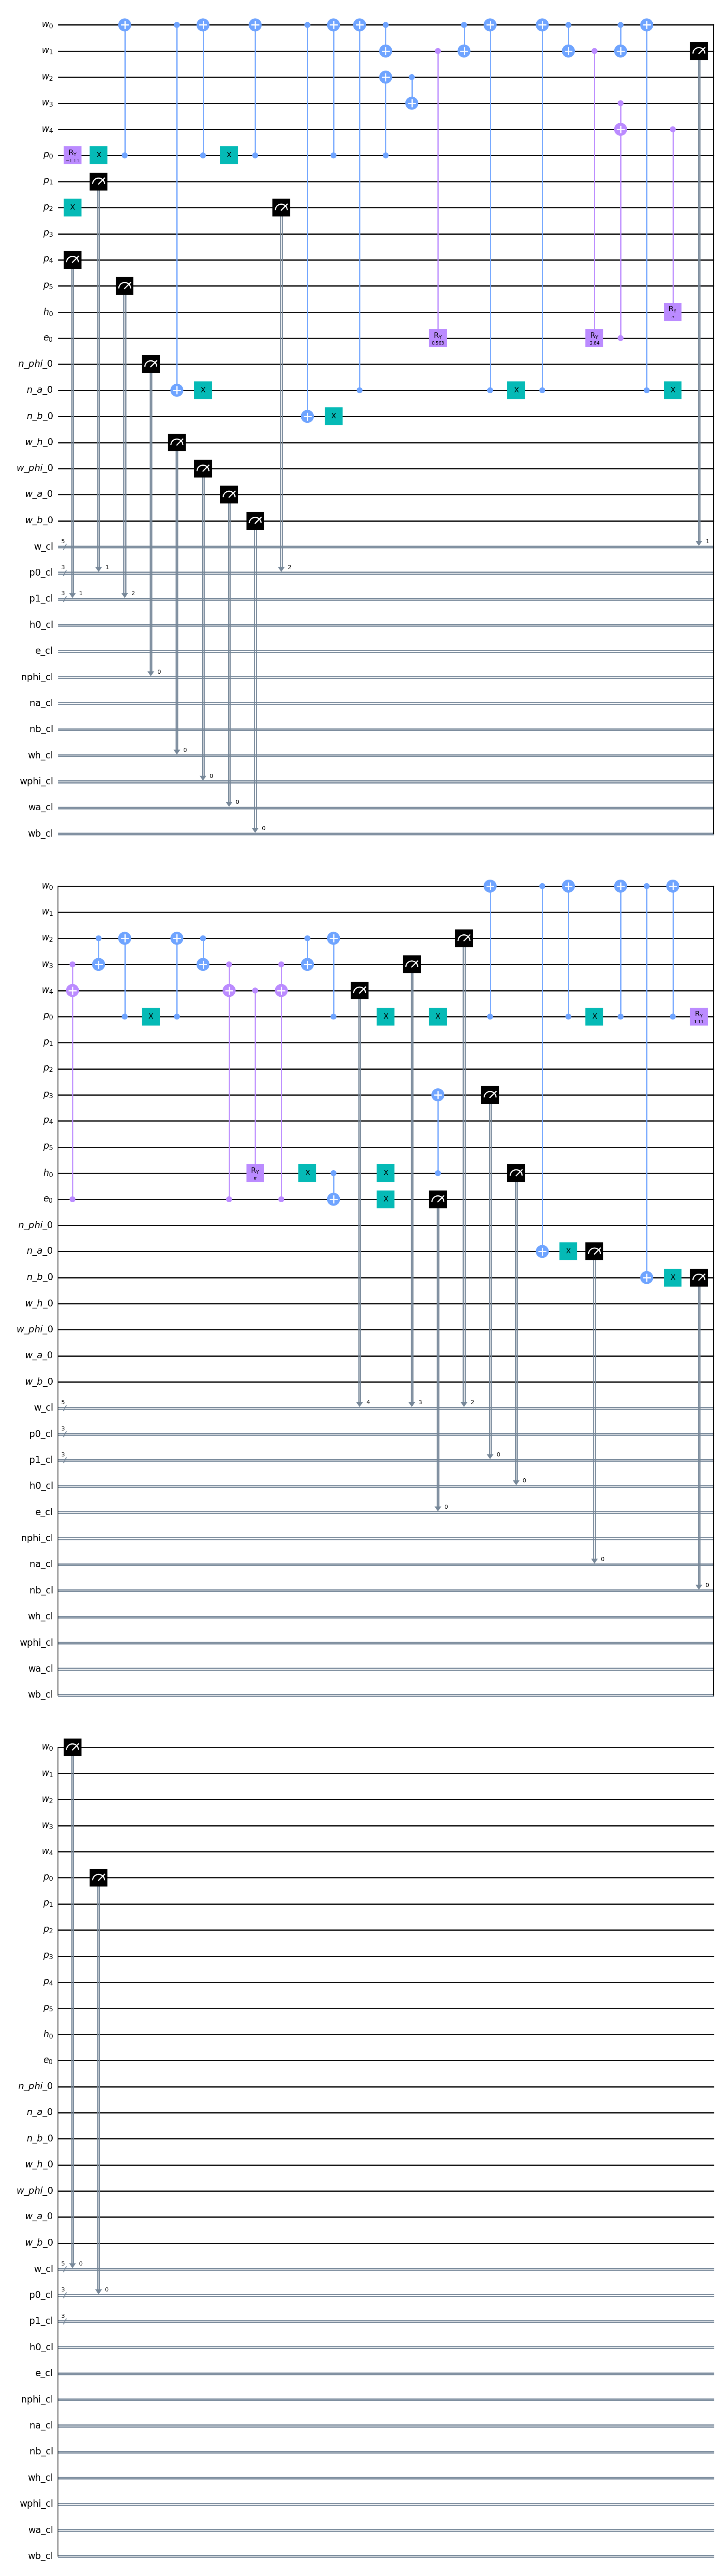

In [ ]:
qc5.draw('mpl')

In [ ]:
Nstep_before_AQCEL = qc0
Nstep_after_AQCEL  = qc5

In [ ]:
#########################  OQPS  ################################



# ver5.2

############################################
##### decide which real machine to use #####
############################################
backend_name = 'ibm_kawasaki'

############################
##### import libraries #####
############################
%matplotlib inline
%load_ext autoreload
%autoreload 2


from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, compiler, circuit, compiler
from qiskit.converters import circuit_to_dag, dag_to_circuit
from pytket.extensions.qiskit import IBMQBackend, AerBackend
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import math
import time
import sys
sys.path.append('../../../aqcel_dev/aqcel_dev')
sys.path.append('../../../CD_Transpiler_demo_ising_PSJangM/sample/')
import aqcel_dev as icepp

from onestepSim_LBNL import runQuantum1
from twostepSim_LBNL import runQuantum2

sim_b = AerBackend()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
qc0 = runQuantum1(gLR=1,dophisplit=1)#circuit_LBNL1

In [ ]:
#######################
##### apply aqcel #####
#######################

# AQCELにかかる時間を測定開始
start_time = time.time()

# AQCELのapply
target_qc = qc0
aqcel_results_cc= icepp.pass_manager(target_qc, level=2, backend_tket=sim_b, shots=1024, measure_type='cc').auto_manager()
result_qc = aqcel_results_cc[0]

# qc1, qc2, qc3, qc4, qc6 = aqcel_results_cc[9], aqcel_results_cc[10], aqcel_results_cc[11], aqcel_results_cc[12], aqcel_results_cc[1]

# AQCEL適用にかかった時間をprint
end_time = time.time()
execution_time = end_time - start_time
print(f"実行時間: {execution_time}秒")

実行時間: 0.9136199951171875秒


In [ ]:
#############################
##### Before AQCEL(qc) #####
#############################
qc = target_qc
print('Before AQCEL(qc)')
print(f' - Number of gate   : {list(target_qc.count_ops().items())}')
print(f' - Number of qubits : {target_qc.num_qubits}')
print(f' - Depth of all     : {target_qc.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')

############################
##### After AQCEL(qc5) #####
############################
qc5 = result_qc
print('After AQCEL(qc5) : After remove_qubits')
print(f' - Number of gate   : {list(result_qc.count_ops().items())}')
print(f' - Number of qubits : {result_qc.num_qubits}')
print(f' - Depth of all     :{result_qc.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')


# かかる時間を測定開始
start_time = time.time()

import qiskit.quantum_info as qi
statevector1 = icepp.simulator(target_qc).statevector_simulator(output='statevector')
statevector2 = icepp.simulator(result_qc).statevector_simulator(output='statevector')
dm1 = qi.partial_trace(statevector1,[6, 7, 8, 9, 10])
dm1.probabilities_dict()
dm2 = qi.partial_trace(statevector2,[6, 7, 8, 9, 10, 11, 12])
dm2.probabilities_dict()

# かかった時間をprint
end_time = time.time()
execution_time = end_time - start_time
print(f"実行時間: {execution_time}秒")
print(f"Fsim = {qi.state_fidelity(dm1,dm2)}")

Before AQCEL(qc)
 - Number of gate   : [('x', 19), ('measure', 6), ('cry', 5), ('mcx', 4), ('c4ry', 2), ('cx', 1)]
 - Number of qubits : 11
 - Depth of all     : 21


After AQCEL(qc5) : After remove_qubits
 - Number of gate   : [('cx', 21), ('x', 7), ('measure', 6), ('cry', 4), ('rccx', 4), ('ry', 2)]
 - Number of qubits : 13
 - Depth of all     :35


実行時間: 0.3860738277435303秒
Fsim = 1.000000000000012


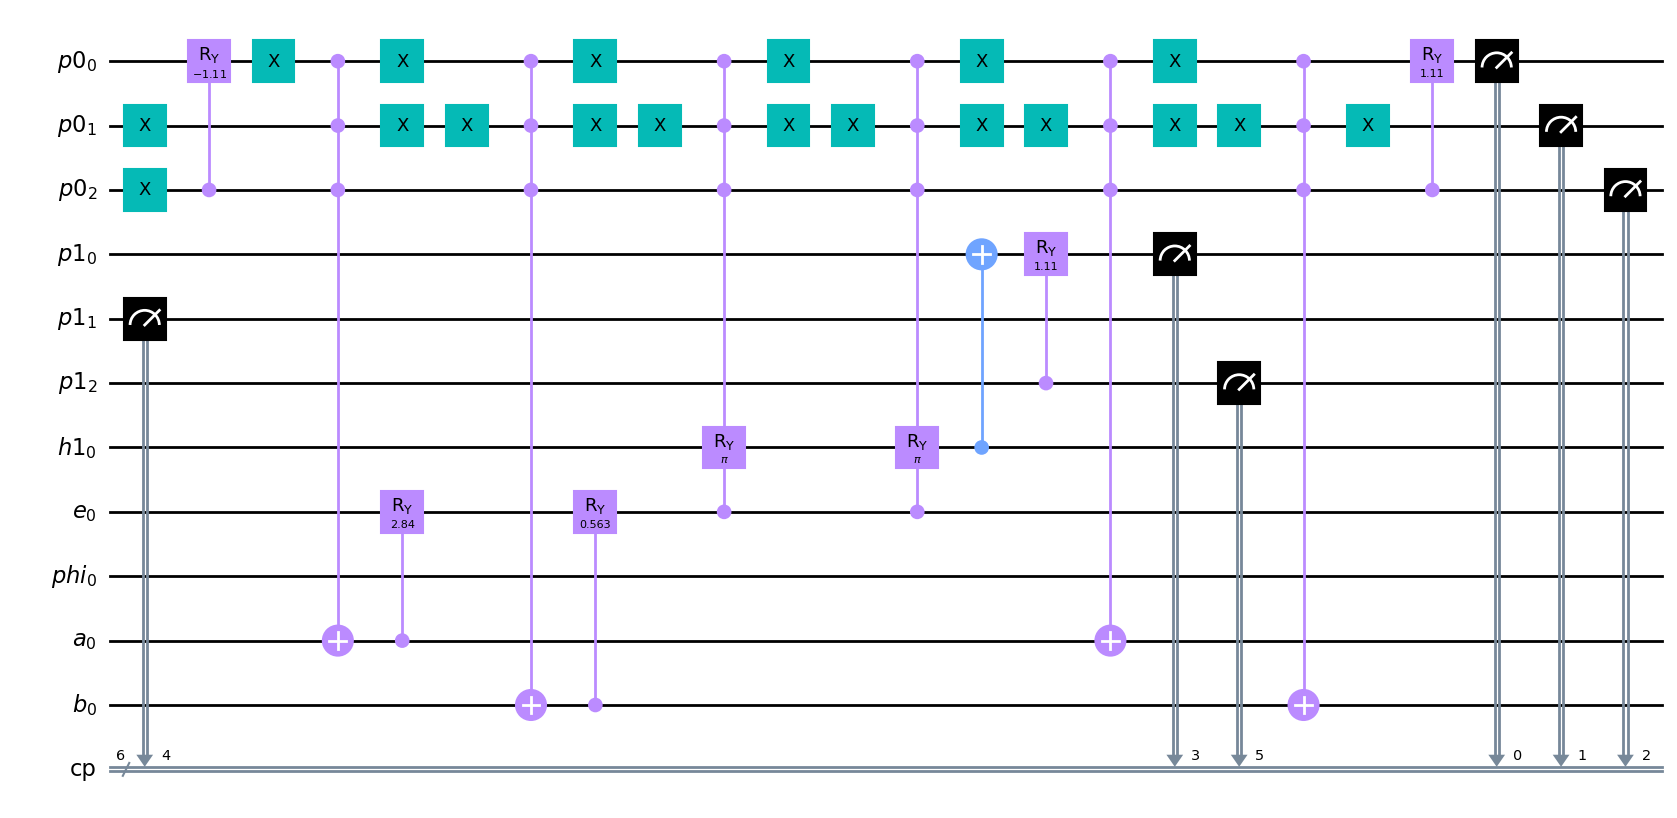

In [ ]:
qc0.draw('mpl')

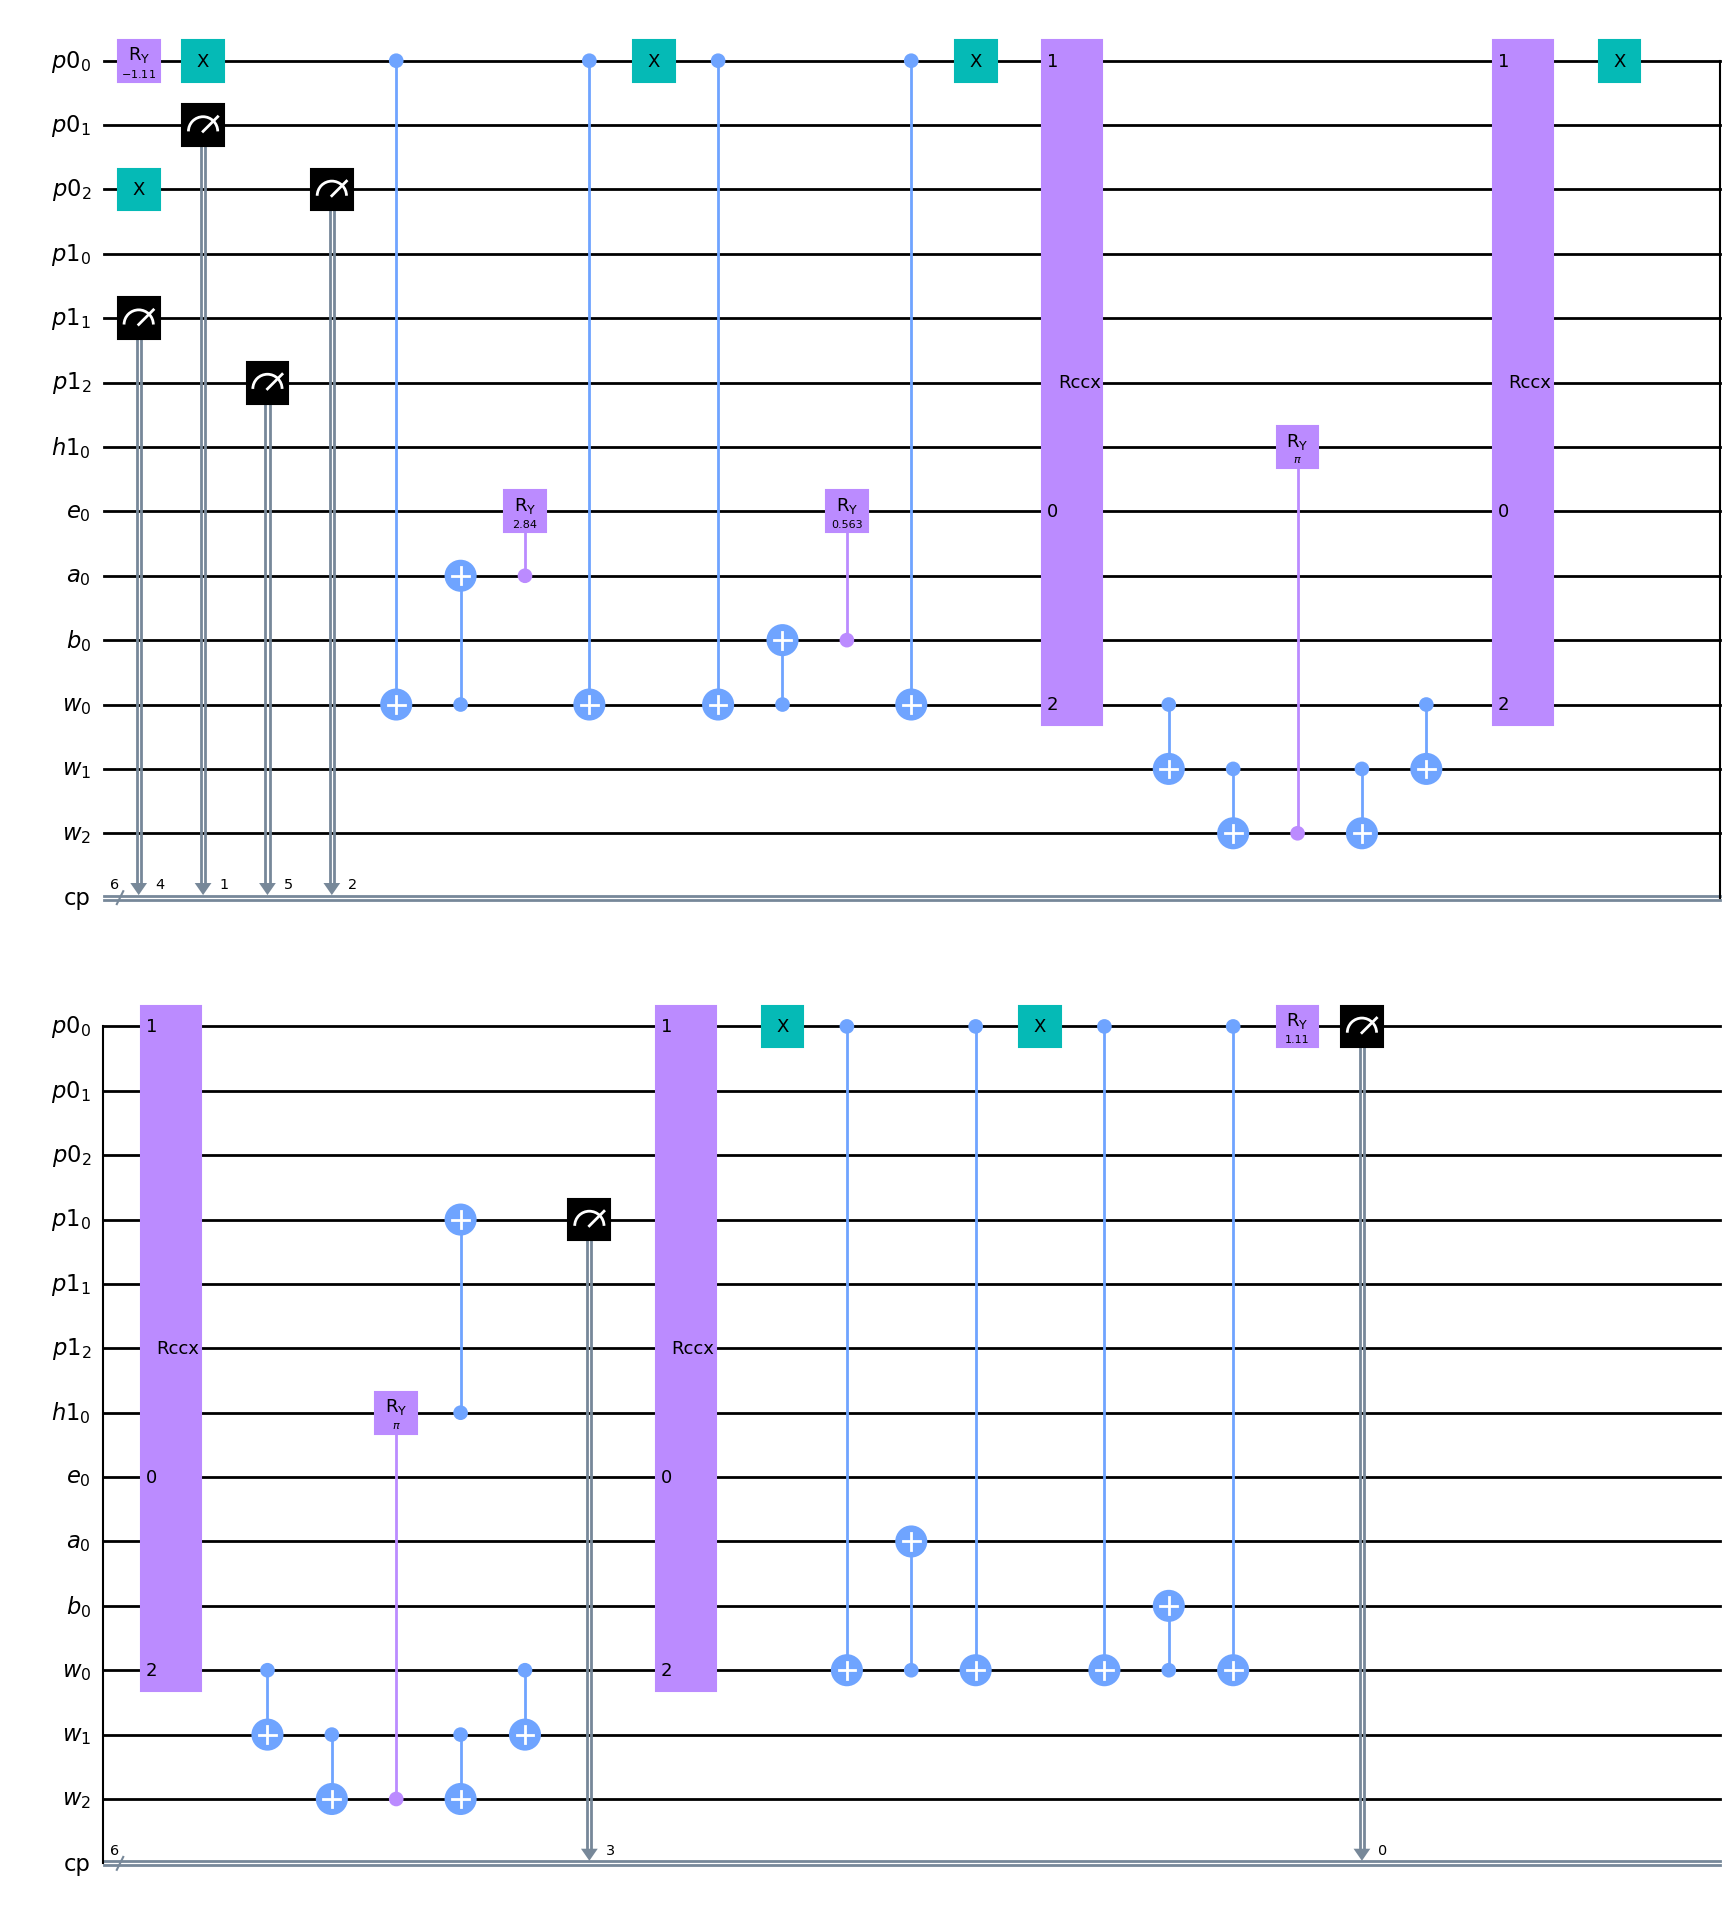

In [ ]:
qc5.draw('mpl')

In [ ]:
Optimized_before_AQCEL = qc0
Optimized_after_AQCEL  = qc5

In [ ]:
############################
##### Before AQCEL(qc5)(decomposed) #####
############################
qc0_decomposed = qc0.decompose()
print('Before AQCEL(qc5)(decomposed)')
print(f' - Number of gate   : {list(qc0_decomposed.count_ops().items())}')
print(f' - Number of qubits : {qc0_decomposed.num_qubits}')
print(f' - Depth of all     :{qc0_decomposed.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')


############################
##### After AQCEL(qc5)(decomposed) #####
############################
qc5_decomposed = qc5.decompose()
print('After AQCEL(qc5)(decomposed)')
print(f' - Number of gate   : {list(qc5_decomposed.count_ops().items())}')
print(f' - Number of qubits : {qc5_decomposed.num_qubits}')
print(f' - Depth of all     :{qc5_decomposed.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')

Before AQCEL(qc5)(decomposed)
 - Number of gate   : [('cx', 155), ('p', 120), ('u', 60), ('u3', 19), ('ry', 10), ('h', 8), ('measure', 6)]
 - Number of qubits : 11
 - Depth of all     :256


After AQCEL(qc5)(decomposed)
 - Number of gate   : [('cx', 41), ('u1', 16), ('ry', 8), ('u2', 8), ('u3', 7), ('measure', 6), ('r', 2)]
 - Number of qubits : 13
 - Depth of all     :68




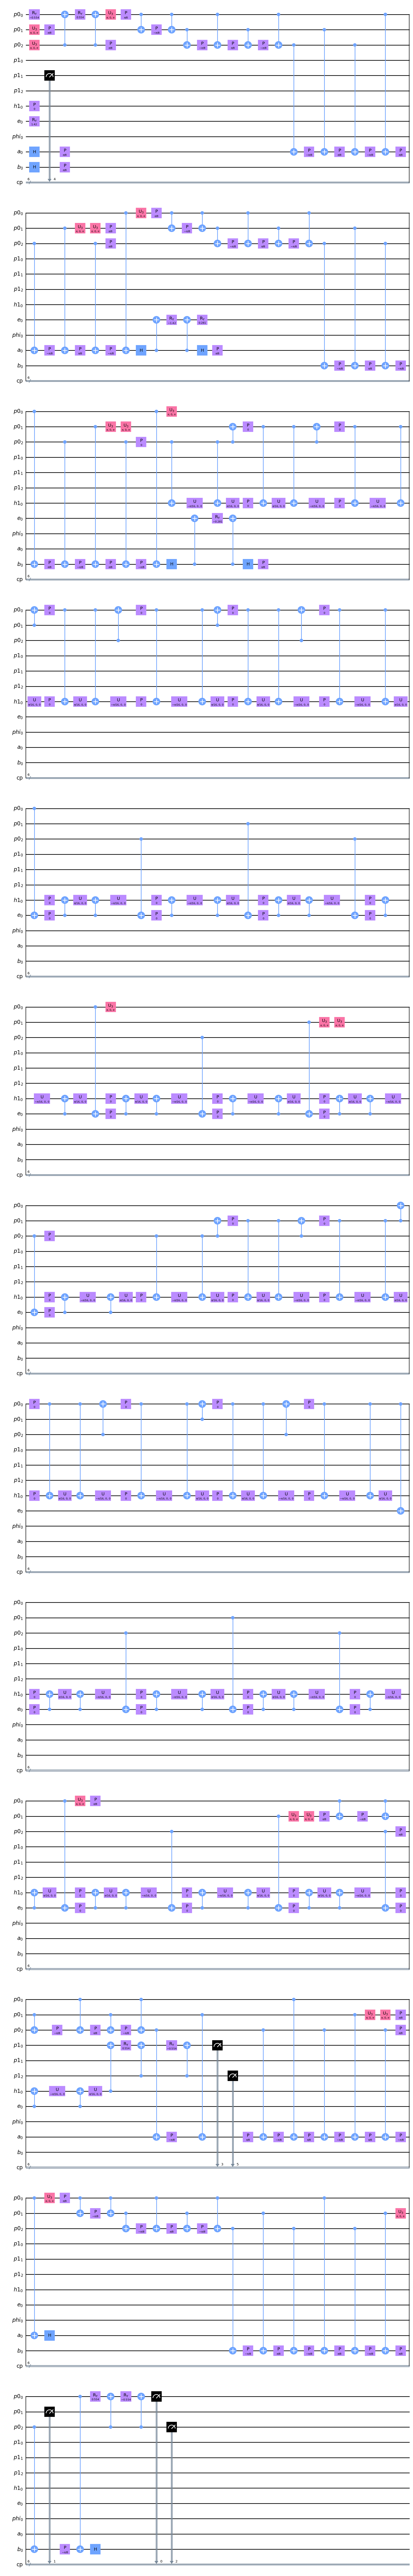

In [ ]:
qc0_decomposed.draw('mpl')

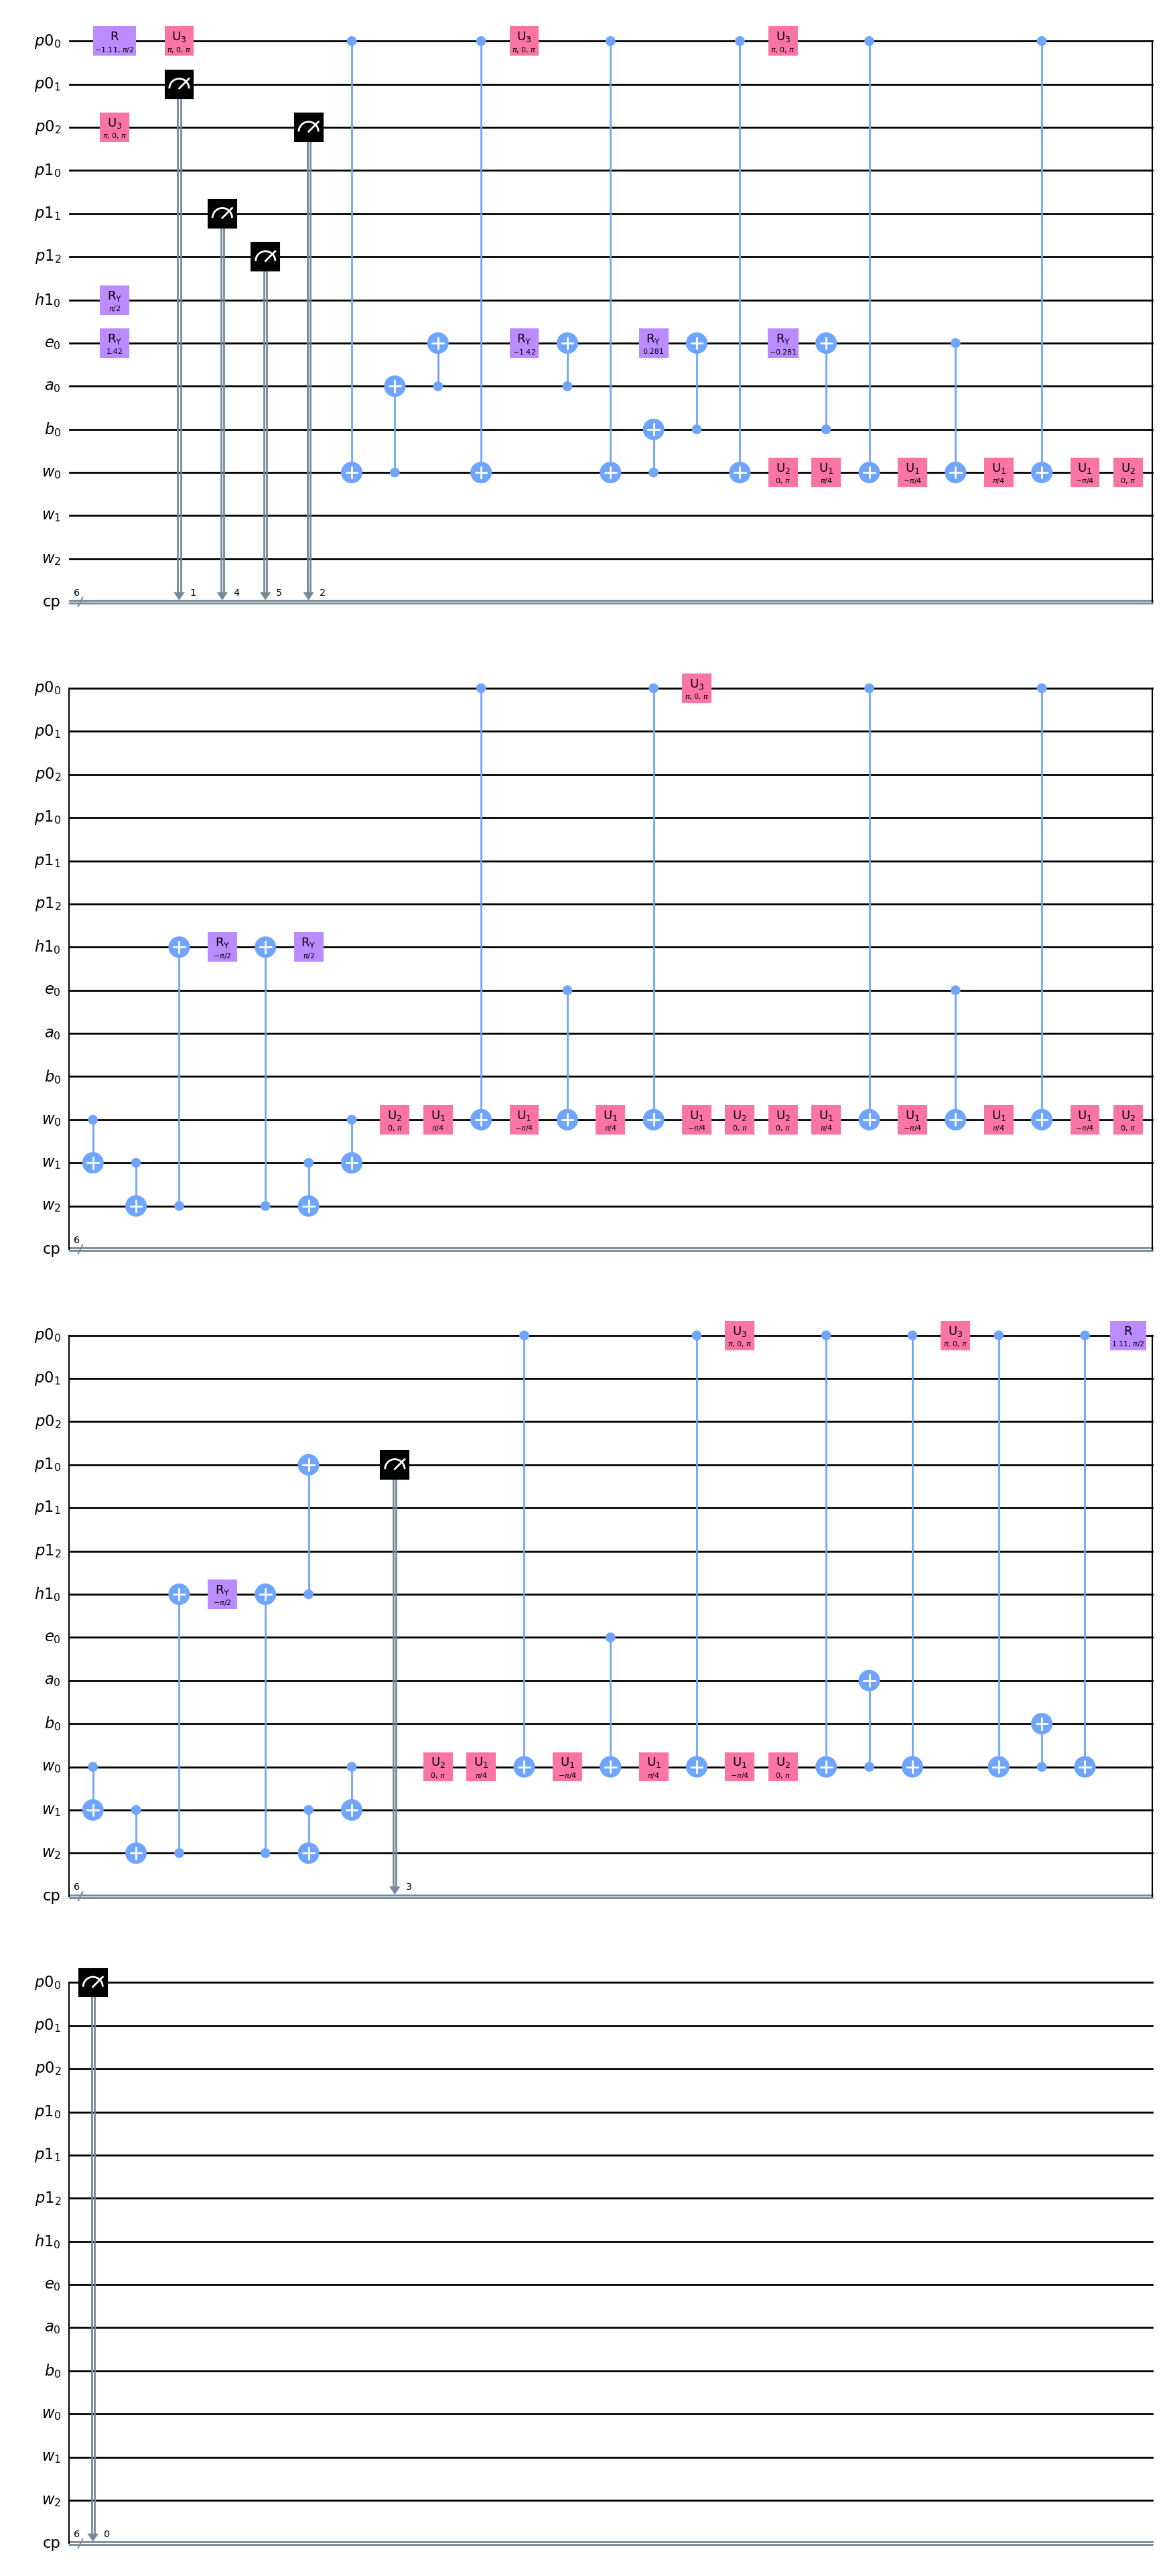

In [ ]:
qc5_decomposed.draw('mpl')

In [ ]:
# qc1←→qc1'

statevector1 = icepp.simulator(Nstep_before_AQCEL).statevector_simulator(output='statevector')
statevector2 = icepp.simulator(Nstep_after_AQCEL).statevector_simulator(output='statevector')
dm1 = qi.partial_trace(statevector1,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm1.probabilities_dict()
dm2 = qi.partial_trace(statevector2,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm2.probabilities_dict()

print(f"Fsim qc1←→qc1' = {qi.state_fidelity(dm1,dm2)}")

Fsim qc1←→qc1' = 1.0000000000000075


In [ ]:
# qc2←→qc2'

statevector1 = icepp.simulator(Optimized_before_AQCEL).statevector_simulator(output='statevector')
statevector2 = icepp.simulator(Optimized_after_AQCEL).statevector_simulator(output='statevector')
dm1 = qi.partial_trace(statevector1,[6, 7, 8, 9, 10])
dm1.probabilities_dict()
dm2 = qi.partial_trace(statevector2,[6, 7, 8, 9, 10, 11, 12])
dm2.probabilities_dict()

print(f"Fsim qc2←→qc2' = {qi.state_fidelity(dm1,dm2)}")

Fsim qc2←→qc2' = 1.000000000000012


In [ ]:
# qc1←→qc2

statevector1 = icepp.simulator(Nstep_before_AQCEL).statevector_simulator(output='statevector')
statevector2 = icepp.simulator(Optimized_before_AQCEL).statevector_simulator(output='statevector')
dm1 = qi.partial_trace(statevector1,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm1.probabilities_dict()
dm2 = qi.partial_trace(statevector2,[6, 7, 8, 9, 10])
dm2.probabilities_dict()

print(f"Fsim qc1←→qc2 = {qi.state_fidelity(dm1,dm2)}")

Fsim qc1←→qc2 = 1.0000000000000124


In [ ]:
# qc1'←→qc2'

statevector1 = icepp.simulator(Nstep_after_AQCEL).statevector_simulator(output='statevector')
statevector2 = icepp.simulator(Optimized_after_AQCEL).statevector_simulator(output='statevector')
dm1 = qi.partial_trace(statevector1,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm1.probabilities_dict()
dm2 = qi.partial_trace(statevector2,[6, 7, 8, 9, 10, 11, 12])
dm2.probabilities_dict()

print(f"Fsim qc1'←→qc2' = {qi.state_fidelity(dm1,dm2)}")

Fsim qc1'←→qc2' = 1.0000000000000075
